# **Gojek App Review Sentiment Classification**

### **Introduction**
Di era transformasi digital, aplikasi layanan berbasis mobile seperti Gojek telah menjadi bagian penting dalam aktivitas sehari-hari masyarakat Indonesia. Sebagai salah satu pelopor aplikasi super di Asia Tenggara, Gojek menawarkan berbagai layanan seperti transportasi online, pesan-antar makanan, pembayaran digital, hingga pengiriman barang dan layanan keuangan.

Dengan tingginya jumlah pengguna aktif, Gojek menerima ribuan ulasan (review) setiap harinya melalui platform seperti Google Play Store. Review ini mencerminkan opini, kritik, maupun apresiasi pengguna terhadap layanan yang disediakan. Karena data tersebut berbentuk teks tidak terstruktur dan berjumlah besar, proses analisis secara manual menjadi sangat tidak efisien.

Untuk mengatasi hal ini, digunakan pendekatan Natural Language Processing (NLP) guna mengolah data teks menjadi informasi yang dapat dipahami dan dimanfaatkan. Salah satu fokus utama dalam analisis ini adalah klasifikasi sentimen, yaitu memetakan ulasan ke dalam kategori positif atau negatif.

Dalam proyek ini, digunakan model Extreme Gradient Boosting (XGBoost), yaitu salah satu algoritma machine learning yang terkenal dengan performa tinggi, efisiensi, dan kemampuan menangani data tidak seimbang. XGBoost digunakan untuk mempelajari pola dalam teks review pengguna dan mengklasifikasikannya berdasarkan sentimen yang terkandung di dalamnya. Dengan menerapkan XGBoost pada data review Gojek, diharapkan dapat dihasilkan model klasifikasi sentimen yang akurat, sehingga dapat memberikan insight strategis bagi tim pengembang aplikasi.

## **Import Libraries**

In [1]:
#libraries yang diperlukan untuk melakukan analisis
import pandas as pd
import numpy as np
import re
import emoji
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from string import punctuation
import nltk
from nltk.corpus import stopwords as nltk_stopwords
nltk.download('stopwords')
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk import ngrams
from collections import Counter
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Joanna\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **Dataset**

In [2]:
df = pd.read_csv('gojek_app_review.csv')
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,88f632f5-710d-4380-995d-016be2c8ac06,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"maaf bnget, pengalaman saya setiap pake gojek ...",1,0,5.14.2,2025-04-09 20:20:22,"Hai Kak Alda, mohon maaf atas ketidaknyamanann...",2025-04-09 23:22:35,5.14.2
1,e4159552-efe0-45ad-aae8-5b4276fc54e3,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,mantep,5,0,5.14.2,2025-04-09 20:19:52,NaN,NaN,5.14.2
2,1faacce2-2f84-46fd-97dc-e3b283ee40af,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,dari dulu emang keren.....,5,0,5.14.2,2025-04-09 20:19:28,NaN,NaN,5.14.2
3,cb7fce78-2416-4be6-96cb-a9f2d4953772,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,mantap sekali👍,5,0,5.15.1,2025-04-09 20:08:11,NaN,NaN,5.15.1
4,092e8756-b866-4699-9d23-5f010b3e3b7f,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,mantab gan,5,0,5.14.2,2025-04-09 20:03:43,NaN,NaN,5.14.2


**Filtering Dataset**

Sampel diambil sejumlah 10.000 dari 270.000 sampel secara acak. Sampel yang diambil hanya yang memiliki score atau rating 1, 2, 4, dan 5 serta tidak ada emoji dalam kalimatnya. Pengambilang sampel ini dilakukan untuk mempercepat proses komputasi.

In [3]:
# Fungsi untuk mendeteksi emoji dalam teks
def contains_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002700-\U000027BF"  # dingbats
                           u"\U0001F900-\U0001F9FF"  # supplemental symbols
                           u"\U00002600-\U000026FF"  # miscellaneous symbols
                           u"\U0001FA70-\U0001FAFF"  # extended symbols
                           "]+", flags=re.UNICODE)
    return bool(emoji_pattern.search(str(text)))

# Filter rating 1, 2, 4, 5
df = df[df['score'].isin([1, 2, 4, 5])]

# Hapus baris yang mengandung emoji di kolom komentar (misalnya nama kolom: 'review')
df = df[~df['content'].apply(contains_emoji)]

# Ambil 10.000 sample acak dari data yang sudah difilter
df = df.sample(n=10000, random_state=42)

# Lihat hasil
df.head()


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
266247,16c7e00c-cc3e-43f0-8061-b2e9b4b72935,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Lancar dan baik ga ada masalah,5,0,4.35.1,2022-05-21 09:11:02,NaN,NaN,4.35.1
70445,308b5088-8805-4039-a238-6a0219881ae6,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,gojek tidak bertanggungjawab atas kehilangan h...,1,0,NaN,2024-04-18 22:21:35,"Hai, Kak Aris. Agar barang yang tertinggal leb...",2024-04-19 09:25:50,NaN
222683,9a9c3700-dbc7-42de-a5f2-691f63f0e07c,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Seneng bgt ada aplikasi gojek..sangat membantu...,5,0,4.49.2,2022-08-19 18:02:30,NaN,NaN,4.49.2
54727,7421fe7b-6a8d-4c65-9dc3-97fc5e5067c5,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Driver rama,5,0,4.89.1,2024-07-05 11:03:26,NaN,NaN,4.89.1
233780,1be3e37a-23a4-4116-802c-7fb27e717eea,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Lambbbbat,1,0,4.47.1,2022-07-30 15:52:09,"Hai Herman Syah, mohon maaf untuk kendalanya, ...",2022-07-31 08:25:29,4.47.1


## **Cleaning Data**

In [4]:
df.shape

(10000, 11)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 266247 to 147860
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              10000 non-null  object
 1   userName              10000 non-null  object
 2   userImage             10000 non-null  object
 3   content               10000 non-null  object
 4   score                 10000 non-null  int64 
 5   thumbsUpCount         10000 non-null  int64 
 6   reviewCreatedVersion  7827 non-null   object
 7   at                    10000 non-null  object
 8   replyContent          2720 non-null   object
 9   repliedAt             2720 non-null   object
 10  appVersion            7827 non-null   object
dtypes: int64(2), object(9)
memory usage: 937.5+ KB


In [6]:
df = df.drop(columns=['reviewId', 'userName', 'userImage', 'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent', 'repliedAt', 'appVersion'])
df.head()

,content,score
266247,Lancar dan baik ga ada masalah,5
70445,gojek tidak bertanggungjawab atas kehilangan h...,1
222683,Seneng bgt ada aplikasi gojek..sangat membantu...,5
54727,Driver rama,5
233780,Lambbbbat,1


In [7]:
df.isnull().sum()

content    0
score      0
dtype: int64

## **Text Preprocessing**

**cleaning data**

In [8]:
def preprocessing_teks(teks):
    teks = str(teks).lower()  # lowercase
    teks = re.sub(r"http\S+", "", teks)  # hapus URL
    teks = re.sub(r"@\w+|#", "", teks)  # hapus mention dan hashtag
    teks = re.sub(r"[^\w\s]", "", teks)  # hapus tanda baca
    teks = re.sub(r"\d+", "", teks)  # hapus angka
    teks = re.sub(r"\s+", " ", teks).strip()  # hapus spasi berlebih
    return teks

df['content_bersih'] = df['content'].apply(preprocessing_teks)
df[['content', 'content_bersih']].head()

,content,content_bersih
266247,Lancar dan baik ga ada masalah,lancar dan baik ga ada masalah
70445,gojek tidak bertanggungjawab atas kehilangan h...,gojek tidak bertanggungjawab atas kehilangan h...
222683,Seneng bgt ada aplikasi gojek..sangat membantu...,seneng bgt ada aplikasi gojeksangat membantuku...
54727,Driver rama,driver rama
233780,Lambbbbat,lambbbbat


**normalisasi kata tidak baku**

In [9]:
normalisasi_kata = {
    'gak': 'tidak',
    'ga': 'tidak',
    'nggak': 'tidak',
    'ngga': 'tidak',
    'tdk': 'tidak',
    'enggak': 'tidak',
    'tak': 'tidak',
    'gk' : 'tidak',
    'gitu': 'seperti itu',
    'gini': 'seperti ini',
    'gtu': 'seperti itu',
    'gt': 'seperti itu',
    'aja': 'saja',
    'aj': 'saja',
    'udh': 'sudah',
    'udah': 'sudah',
    'dah': 'sudah',
    'blm': 'belum',
    'belom': 'belum',
    'bgt': 'banget',
    'bngt': 'banget',
    'bgd': 'banget',
    'bgtu': 'begitu',
    'sm': 'sama',
    'smua': 'semua',
    'semua': 'semua',
    'dgn': 'dengan',
    'dg': 'dengan',
    'ama': 'sama',
    'sama2': 'sama-sama',
    'makasih': 'terima kasih',
    'makasi': 'terima kasih',
    'makasihhh': 'terima kasih',
    'thx': 'terima kasih',
    'thanks': 'terima kasih',
    'thankyou': 'terima kasih',
    'pls': 'tolong',
    'tolongin': 'tolong',
    'plis': 'tolong',
    'tolonglah': 'tolong',
    'plz': 'tolong',
    'bsk': 'besok',
    'bsok': 'besok',
    'kmrn': 'kemarin',
    'kemaren': 'kemarin',
    'kmren': 'kemarin',
    'skrg': 'sekarang',
    'skrang': 'sekarang',
    'skrng': 'sekarang',
    'dr': 'dari',
    'drpd': 'daripada',
    'kalo': 'kalau',
    'kl': 'kalau',
    'klu': 'kalau',
    'kluarga': 'keluarga',
    'klg': 'keluarga',
    'gw': 'saya',
    'gue': 'saya',
    'gua': 'saya',
    'sy': 'saya',
    'aq': 'aku',
    'aku': 'saya',
    'loe': 'kamu',
    'lu': 'kamu',
    'lo': 'kamu',
    'elu': 'kamu',
    'u': 'kamu',
    'km': 'kamu',
    'kmu': 'kamu',
    'ntar': 'nanti',
    'trus': 'terus',
    'trs': 'terus',
    'tp': 'tapi',
    'tpi': 'tapi',
    'knp': 'kenapa',
    'krn': 'karena',
    'karna': 'karena',
    'jg': 'juga',
    'ajaib': 'ajaib',
    'bikin': 'membuat',
    'cuma': 'hanya',
    'cuman': 'hanya',
    'mlm': 'malam',
    'pagi2': 'pagi-pagi',
    'bangunin': 'membangunkan',
    'apk': 'aplikasi',
    'jls': 'jelas',
    'ngk': 'tidak',
    'rb' : 'ribu',
    'bsa': 'bisa',
    'ak': 'saya',
    'yg': 'yang',
    'yng': 'yang'
}


def normalisasi_teks(teks, kamus):
    kata = teks.split()
    hasil = [kamus.get(k, k) for k in kata]
    return ' '.join(hasil)

df['content_normalisasi'] = df['content_bersih'].apply(lambda x: normalisasi_teks(x, normalisasi_kata))
df[['content_bersih','content_normalisasi']].head()

,content_bersih,content_normalisasi
266247,lancar dan baik ga ada masalah,lancar dan baik tidak ada masalah
70445,gojek tidak bertanggungjawab atas kehilangan h...,gojek tidak bertanggungjawab atas kehilangan h...
222683,seneng bgt ada aplikasi gojeksangat membantuku...,seneng banget ada aplikasi gojeksangat membant...
54727,driver rama,driver rama
233780,lambbbbat,lambbbbat


**stopword removal**


In [10]:
# ambil stopword dari sastrawi
factory = StopWordRemoverFactory()
stopwords_sastrawi = factory.get_stop_words()

# ambil stopword dari NLTK (bahasa indonesia)
stopwords_nltk = nltk_stopwords.words('indonesian')

# gabungkan keduanya jadi 1 set
stopwords_gabungan = set(stopwords_sastrawi).union(set(stopwords_nltk))

def remove_stopwords(teks):
    tokens = teks.split()  # tokenisasi manual
    tokens_bersih = [t for t in tokens if t not in stopwords_gabungan]
    return ' '.join(tokens_bersih)

df['content_stopwords'] = df['content_normalisasi'].apply(remove_stopwords)
df[['content_normalisasi', 'content_stopwords']].head()

,content_normalisasi,content_stopwords
266247,lancar dan baik tidak ada masalah,lancar
70445,gojek tidak bertanggungjawab atas kehilangan h...,gojek bertanggungjawab kehilangan hp tertingga...
222683,seneng banget ada aplikasi gojeksangat membant...,seneng banget aplikasi gojeksangat membantuku ...
54727,driver rama,driver rama
233780,lambbbbat,lambbbbat


**stemming**

In [11]:
# Buat stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Function untuk stemming
def stemming_text(text):
    return stemmer.stem(text)


# Terapkan stemming ke kolom clean_text
df['content_stemmed'] = df['content_stopwords'].apply(stemming_text)
df[['content_stopwords', 'content_stemmed']].head()

,content_stopwords,content_stemmed
266247,lancar,lancar
70445,gojek bertanggungjawab kehilangan hp tertingga...,gojek bertanggungjawab hilang hp tinggal mobil...
222683,seneng banget aplikasi gojeksangat membantuku ...,neng banget aplikasi gojeksangat bantu jalan
54727,driver rama,driver rama
233780,lambbbbat,lambbbbat


## **Text Exploration**

**frekuensi kata**

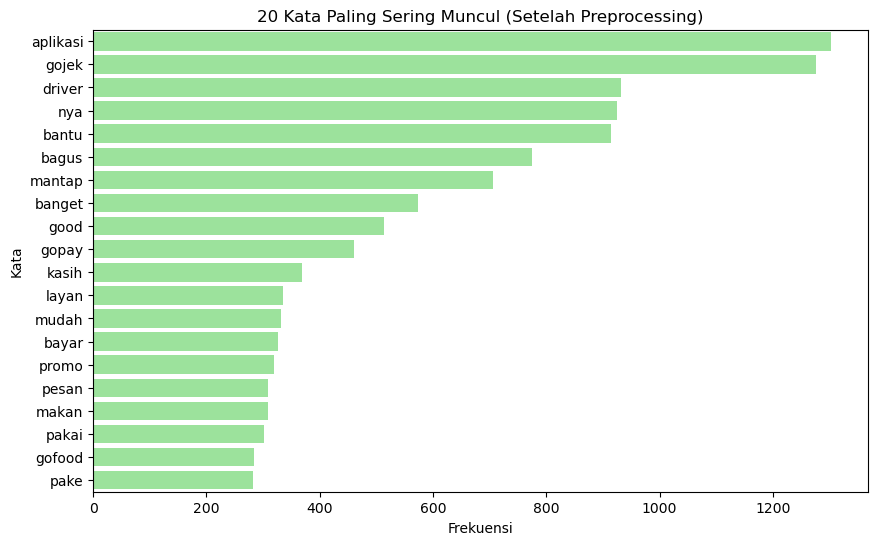

In [12]:
def get_word_freq(df_column):
    from collections import Counter
    all_words = ' '.join(df_column).split()
    word_counts = Counter(all_words)
    return pd.DataFrame(word_counts.most_common(), columns=['kata', 'frekuensi'])

frekuensi_kata = get_word_freq(df['content_stemmed'])
frekuensi_kata.head(10)

plt.figure(figsize=(10,6))
sns.barplot(x='frekuensi', y='kata', data=frekuensi_kata.head(20), color='lightgreen')
plt.title('20 Kata Paling Sering Muncul (Setelah Preprocessing)')
plt.xlabel('Frekuensi')
plt.ylabel('Kata')
plt.show()

**frekuensi kata dengan n-gram**

In [13]:
# Gabungkan semua teks setelah preprocessing
all_text = ' '.join(df['content_stemmed'])  # Ubah ke kolom kamu yang sesuai
tokens = all_text.split()

# Buat bigram dan trigram
bigrams = list(ngrams(tokens, 2))
trigrams = list(ngrams(tokens, 3))

# Hitung frekuensinya
bigram_freq = Counter(bigrams)
trigram_freq = Counter(trigrams)

# Tampilkan top 10
print("Top 10 Bigram:")
print(pd.DataFrame(bigram_freq.most_common(10), columns=['Bigram', 'Frequency']))

print("\nTop 10 Trigram:")
print(pd.DataFrame(trigram_freq.most_common(10), columns=['Trigram', 'Frequency']))

Top 10 Bigram:
              Bigram  Frequency
0    (terima, kasih)        165
1  (aplikasi, gojek)        113
2    (aplikasi, nya)        108
3      (driver, nya)         89
4  (aplikasi, bantu)         73
5  (aplikasi, bagus)         67
6          (top, up)         66
7     (cari, driver)         57
8        (the, best)         53
9        (good, job)         50

Top 10 Trigram:
                   Trigram  Frequency
0   (terima, kasih, gojek)         35
1   (aplikasi, nya, bagus)         15
2   (bantu, terima, kasih)         14
3          (is, the, best)         12
4         (top, up, saldo)         12
5   (upgrade, gopay, plus)         12
6   (bagus, terima, kasih)         11
7    (karya, anak, bangsa)         11
8    (susah, cari, driver)         11
9  (biar, bintang, bicara)         11


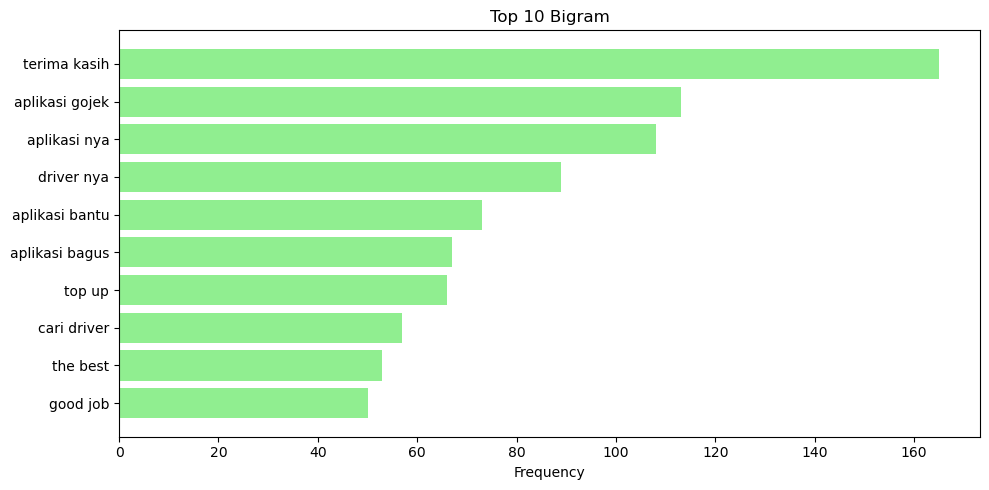

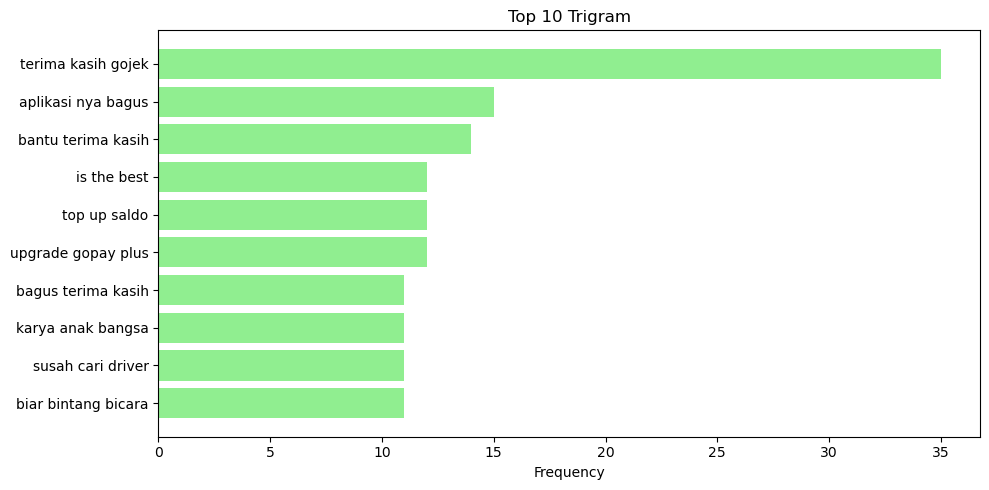

In [14]:
# Fungsi untuk mem-plot n-gram
def plot_ngrams(ngram_freq, title, n=10):
    common_ngrams = ngram_freq.most_common(n)
    phrases = [' '.join(gram) for gram, _ in common_ngrams]
    counts = [count for _, count in common_ngrams]
    
    plt.figure(figsize=(10,5))
    plt.barh(phrases[::-1], counts[::-1], color='lightgreen')
    plt.title(title)
    plt.xlabel('Frequency')
    plt.tight_layout()
    plt.show()

# Plot Bigram
plot_ngrams(bigram_freq, 'Top 10 Bigram')

# Plot Trigram
plot_ngrams(trigram_freq, 'Top 10 Trigram')


**distribusi sentimen**

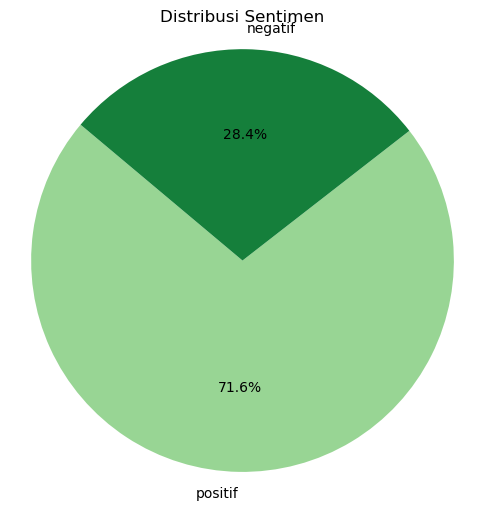

In [15]:
# Terapkan labeling biner
def get_sentiment(score):
    return 'negatif' if score in [1, 2] else 'positif'

df['sentimen'] = df['score'].apply(get_sentiment)

# Hitung jumlah per sentimen
sentimen_counts = df['sentimen'].value_counts()
labels = sentimen_counts.index
sizes = sentimen_counts.values

# Visualisasi pie chart
cmap = plt.cm.Greens
colors = cmap(np.linspace(0.4, 0.8, len(sentimen_counts)))  # Warna biru dan hijau
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribusi Sentimen')
plt.axis('equal')  # Agar pie chart berbentuk lingkaran
plt.show()


**top 10 senimen yang muncul berdasarkan n-gram**


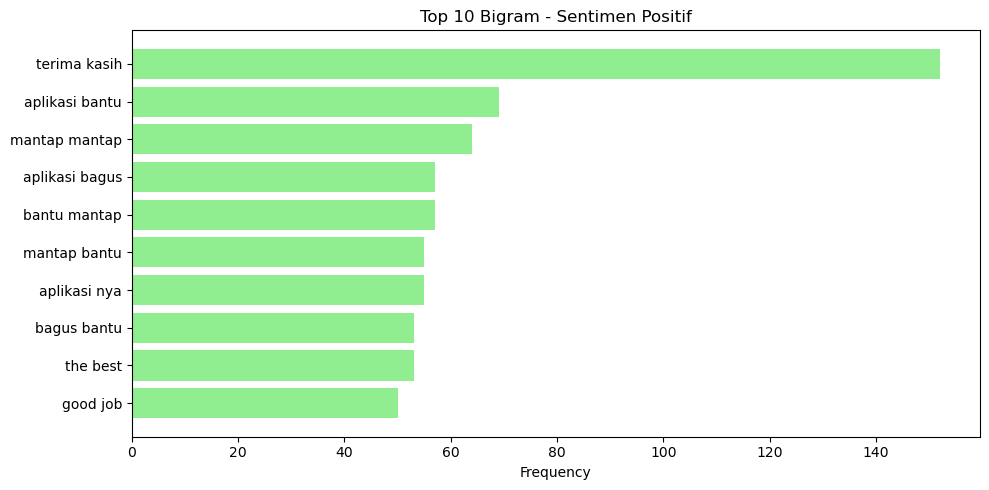

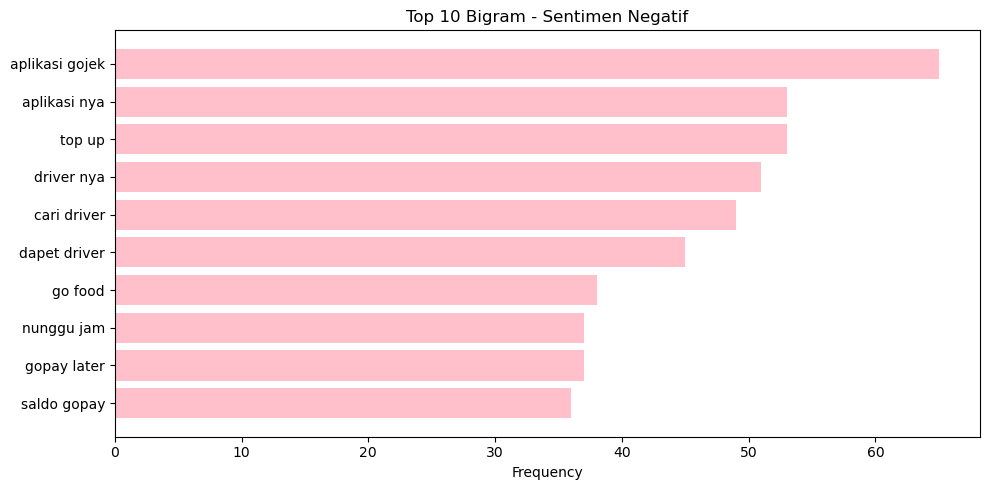

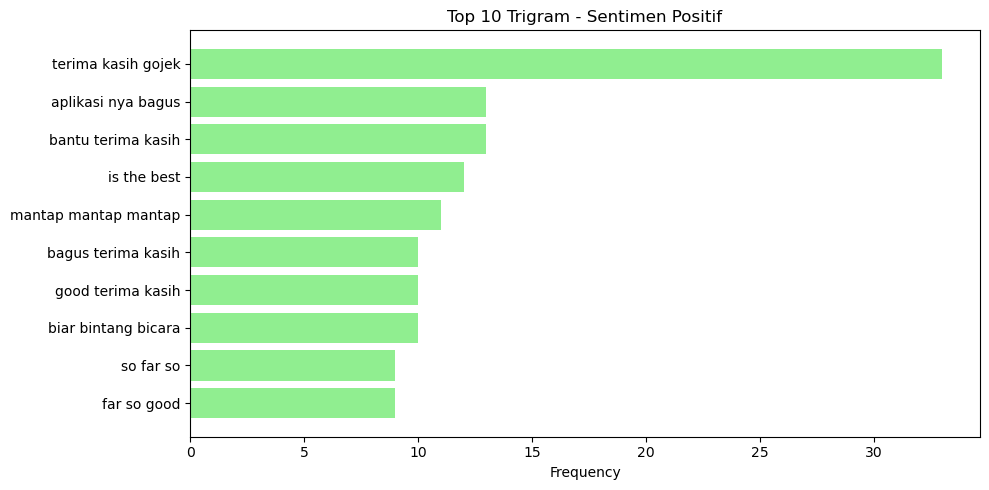

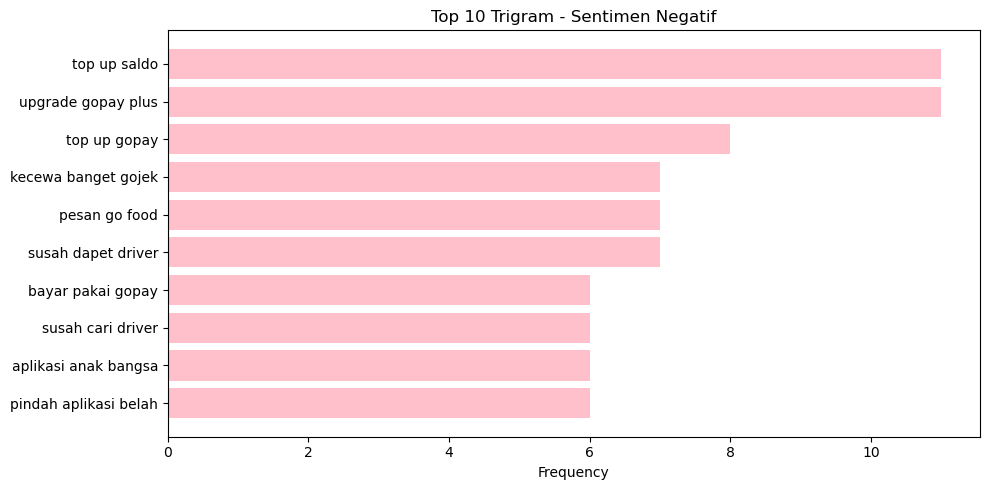

In [16]:
from nltk.util import ngrams
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

# Fungsi untuk ekstrak n-gram dari teks
def get_ngram_freq(texts, n=2):
    all_text = ' '.join(texts)
    tokens = all_text.split()
    n_grams = list(ngrams(tokens, n))
    return Counter(n_grams)

# Fungsi untuk plot n-gram
def plot_ngrams(ngram_freq, title, n=10, color='blue'):
    common_ngrams = ngram_freq.most_common(n)
    phrases = [' '.join(gram) for gram, _ in common_ngrams]
    counts = [count for _, count in common_ngrams]

    plt.figure(figsize=(10, 5))
    plt.barh(phrases[::-1], counts[::-1], color=color)
    plt.title(title)
    plt.xlabel('Frequency')
    plt.tight_layout()
    plt.show()

# Pisahkan data berdasarkan sentimen
positif_texts = df[df['sentimen'] == 'positif']['content_stemmed'].dropna()
negatif_texts = df[df['sentimen'] == 'negatif']['content_stemmed'].dropna()

# Bigram
bigram_positif = get_ngram_freq(positif_texts, n=2)
bigram_negatif = get_ngram_freq(negatif_texts, n=2)

# Trigram
trigram_positif = get_ngram_freq(positif_texts, n=3)
trigram_negatif = get_ngram_freq(negatif_texts, n=3)

# Plot hasil
plot_ngrams(bigram_positif, 'Top 10 Bigram - Sentimen Positif', color='lightgreen')
plot_ngrams(bigram_negatif, 'Top 10 Bigram - Sentimen Negatif', color='pink')

plot_ngrams(trigram_positif, 'Top 10 Trigram - Sentimen Positif', color='lightgreen')
plot_ngrams(trigram_negatif, 'Top 10 Trigram - Sentimen Negatif', color='pink')


## **Modeling**

**maping sentimen ke 0 atau 1**

In [17]:
# Ubah nilai sentimen ke label numerik
df['label'] = df['sentimen'].map({'positif': 1, 'negatif': 0})

**XGBoost default ver.**

In [18]:
# tf-idf
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['content_stemmed'])
y = df['label']

# spliting data 80% & 20%
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  
)

# train model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [19]:
# evaluasi model
y_pred = model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[ 421  146]
 [  82 1351]]

Accuracy: 0.886

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.74      0.79       567
           1       0.90      0.94      0.92      1433

    accuracy                           0.89      2000
   macro avg       0.87      0.84      0.85      2000
weighted avg       0.88      0.89      0.88      2000



**Observasi**

Dari hasil evaluasi model bisa kita lihat bahwa:
* sebanyak 146 review negatif salah diklasifikasikan sebagai positif
* sebanyak 82 review positif salah diklasifikasikan sebagai negatif
* akurasi sebesar 88.6%
* Recall untuk kelas negatif 0.74 dan untuk kelas positif 0.94
* F1-score untuk kelas negatif 0.79 dan untuk kelas positif 0.92 

Artinya, model ini menunjukkan kinerja yang sangat baik pada kelas positif, tetapi masih kesulitan dalam mengidentifikasi kelas negatif. Hal ini terlihat dari:
* Recall negatif yang rendah (0.74): banyak review negatif yang terlewat
* F1-score positif yang tinggi (0.92): seimbang antara precision dan recall pada kelas positif

**Kesimpulan**

Model ini bisa dijadikan sebagai baseline karena sudah menunjukkan akurasi dan F1-score yang tinggi, namun masih perlu ditingkatkan recall kelas negatif agar performa lebih seimbang dan adil untuk kedua kelas.

**XGBoost with SMOTE**

In [20]:
# tf-idf
vectorizer = TfidfVectorizer() 
X_tfidf = vectorizer.fit_transform(df['content_stemmed'])
y = df['label']

# spliting data 80% & 20%
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  
)

# resampling (smote)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# train model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_resampled, y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [21]:
# evaluasi model
y_pred = model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[ 454  113]
 [ 105 1328]]

Accuracy: 0.891

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.80      0.81       567
           1       0.92      0.93      0.92      1433

    accuracy                           0.89      2000
   macro avg       0.87      0.86      0.87      2000
weighted avg       0.89      0.89      0.89      2000



**Observasi**

Dari hasil evaluasi model bisa kita lihat bahwa:
* Sebanyak 113 review negatif salah diklasifikasikan sebagai positif
* Sebanyak 105 review positif salah diklasifikasikan sebagai negatif
* Akurasi sebesar 89.1%
* Recall untuk kelas negatif 0.80 dan untuk kelas positif 0.93
* F1-score untuk kelas negatif 0.81 dan untuk kelas positif 0.92

Artinya, model ini menunjukkan performa yang jauh lebih seimbang dibanding dua model sebelumnya. Hal ini terlihat dari:
* Recall negatif meningkat ke 0.81: menunjukkan bahwa model makin baik dalam menangkap review negatif
* F1-score kelas negatif juga meningkat ke 0.81, yang berarti balance antara precision dan recall makin stabil
* Kelas positif tetap kuat dengan F1-score 0.92, tidak banyak dikorbankan meskipun SMOTE menambahkan data sintetis

**Kesimpulan**

Penggunaan SMOTE berhasil memperbaiki kinerja model terhadap kelas minoritas (negatif), tanpa mengorbankan performa di kelas mayoritas (positif). Model ini cocok digunakan jika kamu ingin mencapai keseimbangan yang lebih adil antar kelas. Namun, perlu diingat bahwa SMOTE menambahkan data sintetis, yang bisa memperbesar ukuran dataset dan berdampak pada waktu pelatihan atau risiko overfitting jika tidak dikontrol dengan baik.

**XGBoost & `scale_pos_weight`**

In [22]:
# tf-idf
vectorizer = TfidfVectorizer(max_features=5000) 
X_tfidf = vectorizer.fit_transform(df['content_stemmed'])
y = df['label']

# spliting data 80% & 20%
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  
)

# hitung `scale_pos_weight`
neg = sum(y_train == 0)
pos = sum(y_train == 1)
scale = neg / pos
print(f"scale_pos_weight: {scale:.2f}")

# train model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_resampled, y_resampled)

scale_pos_weight: 0.40


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [23]:
# evaluasi model 
y_pred = model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nAccuracy:", accuracy_score(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[ 454  113]
 [ 105 1328]]

Accuracy: 0.891

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.80      0.81       567
           1       0.92      0.93      0.92      1433

    accuracy                           0.89      2000
   macro avg       0.87      0.86      0.87      2000
weighted avg       0.89      0.89      0.89      2000



**Observasi**

Dari hasil evaluasi model bisa kita lihat bahwa:
* Sebanyak 113 review negatif salah diklasifikasikan sebagai positif
* Sebanyak 105 review positif salah diklasifikasikan sebagai negatif
* Akurasi sebesar 89.1%
* Recall untuk kelas negatif 0.80 dan untuk kelas positif 0.93
* F1-score untuk kelas negatif 0.81 dan untuk kelas positif 0.92

Artinya, model ini menunjukkan performa yang sangat seimbang untuk kedua kelas. Hal ini terlihat dari:
* Recall kelas negatif (0.80) cukup tinggi, artinya model berhasil menangkap lebih banyak review negatif
* F1-score kelas negatif (0.81) menunjukkan keseimbangan yang baik antara precision dan recall
* Performa pada kelas positif tetap konsisten tinggi (F1-score 0.92), sehingga model tetap andal untuk deteksi review positif

**Kesimpulan**

Penggunaan scale_pos_weight memberikan hasil yang sangat mirip dengan SMOTE, namun dengan pendekatan yang lebih efisien karena tidak menambah data sintetis.
Model ini menjadi pilihan kuat karena:
* Seimbang antara recall dan F1-score di kedua kelas
* Lebih ringan dan cepat dibanding SMOTE
* Tidak menambah kompleksitas data

**Hyperparameter Tuning**

In [24]:
# buat pipeline XGBoost dan TF-IDF
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

# parameter grid
param_grid = {
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [3, 5, 7],
    'xgb__learning_rate': [0.01, 0.1],
    'xgb__subsample': [0.8, 1.0],
    'xgb__scale_pos_weight': [1, df['label'].value_counts()[0] / df['label'].value_counts()[1]]  # optional
}

# spliting data 80% & 20% 
X = df['content_stemmed']
y =  df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# grid search
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)


Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=5000)),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='logloss',
                                                      feature_types=None,
                                                      feature_weights=None,
                                                      gam...
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'xgb__learning_rate': [0.01, 0.1],
                         'xgb__max_depth': [3, 5, 7],
                         'xgb__n_estimators': [100, 200],
                         'xgb__scale_pos_weight': [1, 0.39606310205221273],
                         'xgb__subsample': [0.8, 1.0]},
             scoring='f1', verbose=1)

In [25]:
# evaluasi model
print("Best Parameters:", grid.best_params_)

y_pred = grid.predict(X_test)


print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Best Parameters: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 7, 'xgb__n_estimators': 200, 'xgb__scale_pos_weight': 0.39606310205221273, 'xgb__subsample': 1.0}

Confusion Matrix:
[[ 467  100]
 [ 122 1311]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.82      0.81       567
           1       0.93      0.91      0.92      1433

    accuracy                           0.89      2000
   macro avg       0.86      0.87      0.86      2000
weighted avg       0.89      0.89      0.89      2000



**Observasi**

* Dari hasil evaluasi model bisa kita lihat bahwa:
* Sebanyak 100 review negatif salah diklasifikasikan sebagai positif
* Sebanyak 122 review positif salah diklasifikasikan sebagai negatif
* Akurasi sebesar 89%
* Recall untuk kelas negatif 0.82, dan untuk kelas positif 0.91
* F1-score untuk kelas negatif 0.81, dan untuk kelas positif 0.92

Artinya, model hasil hyperparameter tuning ini menunjukkan performa yang kuat dan cukup seimbang, meskipun:
* F1-score kelas negatif sedikit menurun dibanding model scale_pos_weight default (dari 0.82 ke 0.81)
* Recall kelas negatif juga sedikit turun (dari 0.84 menjadi 0.82)
* Precision kelas negatif mengalami penurunan menjadi 0.79

Namun demikian, model masih menunjukkan F1-score tinggi di kelas positif (0.92), dan macro average F1-score tetap stabil di angka 0.86, menunjukkan performa yang seimbang antar kelas.

**Kesimpulan**

Model dengan hyperparameter tuning memberikan performa yang konsisten dan relatif stabil dibanding model scale_pos_weight default.
* Kelebihan:
    * Mempertahankan akurasi dan F1-score tinggi
    * Lebih fleksibel dan teroptimasi untuk dataset tertentu
* Catatan:
    * Penurunan kecil pada recall dan precision kelas negatif
    * Tidak jauh lebih unggul dibanding model tanpa tuning, tetapi bisa dipilih jika ingin model yang lebih terkontrol secara parameter dan efisiensi
Model ini tetap layak dipertimbangkan terutama jika target utama adalah menjaga keseimbangan antara dua kelas tanpa terlalu banyak trade-off.

## **Kesimpulan dan Rekomendasi**

### **Kesimpulan**

Dari evaluasi model XGBoost dengan pendekatan berbeda (default, SMOTE, scale_pos_weight, dan hyperparameter tuning), dapat disimpulkan:
1. Model Default memberikan baseline yang solid dengan akurasi dan F1-score tinggi pada kelas positif. Namun, recall untuk kelas negatif masih rendah (0.74), yang menunjukkan model kurang sensitif terhadap review negatif.
2. Model dengan SMOTE berhasil meningkatkan recall dan F1-score pada kelas negatif (recall 0.81, F1-score 0.82) tanpa menurunkan performa pada kelas positif (F1-score 0.93). Memberikan keseimbangan antar kelas dan cocok digunakan jika ingin meningkatkan deteksi terhadap kelas minoritas.
3. Model dengan `scale_pos_weight` memberikan hasil yang hampir setara dengan SMOTE, dengan performa seimbang dan efisien. Recall dan F1-score untuk kelas negatif mencapai 0.81 dan 0.82, sementara F1-score kelas positif tetap tinggi di angka 0.93. Kelebihannya adalah tidak menambah data sintetis dan lebih cepat saat pelatihan.
4. Model dengan hyperparameter tuning menunjukkan performa yang stabil dan seimbang, meskipun tidak jauh lebih unggul dari model scale_pos_weight default. Recall dan F1-score kelas negatif sedikit menurun (recall 0.82 → 0.81, F1-score 0.82 → 0.81), namun tetap berada pada level yang baik. Cocok jika ingin kontrol lebih presisi terhadap parameter model.

### **Rekomendasi**

1. Penerapan Threshold Tuning
    * Menyesuaikan threshold prediksi probabilitas untuk meningkatkan F1-score atau recall kelas minoritas (negatif).
    * Gunakan ROC curve atau Precision-Recall curve untuk memilih threshold optimal yang menyeimbangkan precision dan recall.
2. Coba Model Lain untuk Perbandingan (Ensemble atau Non-Tree-Based)
    * LightGBM atau CatBoost: sering lebih cepat dan kadang lebih presisi dibanding XGBoost, terutama untuk teks.
    * Logistic Regression + TF-IDF dengan class weighting: baseline sederhana tapi sering sangat kompetitif.
    * Stacking Ensemble: gabungkan output dari XGBoost, Logistic Regression, dan SVM untuk performa lebih stabil.
3. Feature Selection / Dimensionality Reduction
    * Gunakan Chi-Square, Mutual Information, atau PCA untuk memilih fitur paling informatif.
    * Terutama bermanfaat jika dataset sangat spars dan model rawan overfitting.